In [1]:
import os
import shutil
import PIL
from PIL import Image
import glob as gb
import numpy as np
import pandas as pd
import pylab as plt
from tqdm import tqdm
# import model.resnet50_128 as model
# from pytorch_feature_extractor import initialize_model, image_encoding
from sklearn.model_selection import train_test_split
from facenet_pytorch import MTCNN, InceptionResnetV1,fixed_image_standardization, training, extract_face
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

In [2]:
base_folder = '/home/care1e55/study/MIPT/cv/data/'
names_file = base_folder + 'class_mapping.csv'
IMAGE_SIZE = 160

In [ ]:
# CROP INLY NEED TO RUN ONCE AND SAVE CROPED FACES

In [ ]:
# This only needs to be run once and save croped faces
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
# mtcnn = MTCNN(
#     image_size=160,
#     device=device
# )
mtcnn = MTCNN(
    image_size=IMAGE_SIZE,
    device=device,
    select_largest=False,
    selection_method = "center_weighted_size",
    # post_process=False,
    margin = 14,
    # min_face_size = 20,
)

In [ ]:
# This only needs to be run once and save croped faces
# Here we crop mapping faces
workers = 4
batch_size = 4
data_dir = '/home/care1e55/study/MIPT/cv/data/croped/mapping/'
crop_paths = []
box_probs = []
folder1_dataset = ImageFolder(data_dir)
folder1_dataset.samples = [
    (p, p)
    for p, _ in tqdm(folder1_dataset.samples)
]
folder1_loader = DataLoader(
    folder1_dataset,
    num_workers=workers,
    # batch_size=batch_size,
    collate_fn=training.collate_pil
)
for i, (x, b_paths) in tqdm(enumerate(folder1_loader), total=len(folder1_loader)):
    crops = [p.replace(data_dir, data_dir) for p in b_paths]
    mtcnn(x, save_path=crops)
    crop_paths.extend(crops)
    # print('\rBatch {} of {}'.format(i + 1, len(folder1_loader)), end='')

In [ ]:
# This only needs to be run once and save croped faces
# Here we crop test
workers = 8
batch_size = 4
data_dir = '/home/care1e55/study/MIPT/cv/data/croped/test_data/'
crop_paths = []
box_probs = []
test_dataset = ImageFolder(data_dir)

test_dataset.samples = [
    (p, p)
    for p, _ in tqdm(test_dataset.samples)
]

test_loader = DataLoader(
    test_dataset,
    num_workers=workers,
    # batch_size=batch_size,
    collate_fn=training.collate_pil
)

for i, (x, b_paths) in tqdm(enumerate(test_loader), total=len(test_loader)):
    crops = [p.replace(data_dir, data_dir) for p in b_paths]
    try:
        mtcnn(x, save_path=crops)
    except:
        pass
    crop_paths.extend(crops)

In [ ]:
# Remove mtcnn to reduce GPU memory usage
del mtcnn
torch.cuda.empty_cache()

In [ ]:
# Predict and prepare submit after we have croped images

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [4]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [5]:
resnet = InceptionResnetV1(pretrained='vggface2', classify=False).to(device)
resnet.eval()
print()

In [6]:
trans = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor(),
])

In [7]:
workers = 4
batch_size = 4

def collate_fn(x):
    return x[0]
folder1_dataset = ImageFolderWithPaths('/home/care1e55/study/MIPT/cv/data/croped/mapping/', transform=trans)
folder1_dataset.idx_to_class = {i:c for c, i in folder1_dataset.class_to_idx.items()}
folder1_loader = DataLoader(folder1_dataset, collate_fn=collate_fn, num_workers=workers)

In [8]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]

In [9]:
folder1_aligned = []
folder1_paths = []
folder1_names = []
for x, y, p in tqdm(folder1_loader):
    folder1_aligned.append(x)
    folder1_names.append(y)
    folder1_paths.append(p)

100%|██████████| 500/500 [00:00<00:00, 865.69it/s]


In [10]:
batch_size = 4
imgchunks = list(chunks(folder1_aligned, batch_size))
mapping_embeddings = []
for i, imgs in tqdm(enumerate(imgchunks), total=len(imgchunks)):
    stacked = torch.stack(imgs).to(device)
    mapping_embeddings += resnet(stacked).detach().cuda()
mapping_embeddings = torch.stack(mapping_embeddings).to(device)

100%|██████████| 125/125 [00:03<00:00, 40.82it/s]


In [11]:
batch_size = 64

def collate_fn(x):
    return x

test_dataset = ImageFolderWithPaths('/home/care1e55/study/MIPT/cv/data/croped/test_data/', transform=trans)
test_dataset.idx_to_class = {i:c for c, i in test_dataset.class_to_idx.items()}
test_loader = DataLoader(test_dataset, collate_fn=collate_fn, num_workers=workers, batch_size=batch_size)

In [12]:
predictions = []
for batch in tqdm(test_loader):
    test_aligned = []
    test_paths = []
    for x, y, p in batch:
        test_aligned.append(x)
        test_paths.append(p)

    batch_embeddings = []
    imgchunks = list(chunks(test_aligned, batch_size))
    for i, imgs in enumerate(imgchunks):
        try:
            stacked = torch.stack(imgs).to(device)
        except:
            for k in imgs:
                print(k.size())
            break
        batch_embeddings += resnet(stacked).detach().cuda()
    batch_embeddings = torch.stack(batch_embeddings).to(device)
    # we use cosine similarity (dot product), but also can use distance as:
    # pred_idxs = torch.argmin(torch.cdist(batch_embeddings.detach(), mapping_embeddings.detach(), p=2.0), 1)
    pred_idxs = torch.argmax(torch.mm(batch_embeddings.detach(), mapping_embeddings.T.detach()), 1)
    batch_preds = list(map(folder1_paths.__getitem__, pred_idxs))
    predictions += [j for j in zip([i[2] for i in batch], batch_preds)]

100%|██████████| 2647/2647 [10:41<00:00,  4.12it/s]


In [ ]:
# Now visualize to see what we have predicted

In [13]:
names = pd.read_csv(names_file, delimiter=',', names=['image', 'class'], skiprows=1)
names['image'] = names['image'].apply(str).apply(lambda x: x.split('.')[0])

In [14]:
class FaceImagesClassDataset(Dataset):
    """
    Images Dataset only for printing
    """
    def __init__(self, predictions, names):
        super().__init__()

        self.predictions = predictions
        self.names = names

    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image
    
    def __len__(self):
         return len(predictions)
  
    def __getitem__(self, index):
        predicted = self._prepare_sample(self.load_sample(self.predictions[index][0]))
        source = self._prepare_sample(self.load_sample(self.predictions[index][1]))
        source_num = predictions[index][0].split('/')[-1].split('.')[-2]
        predicted_num = predictions[index][1].split('/')[-1].split('.')[-2]
        predicted_class = names[names['image'] == str(predicted_num)]['class'].iloc[0]
        return predicted, source, predicted_class, predicted_class

In [15]:
face_images_class_dataset = FaceImagesClassDataset(predictions, names)

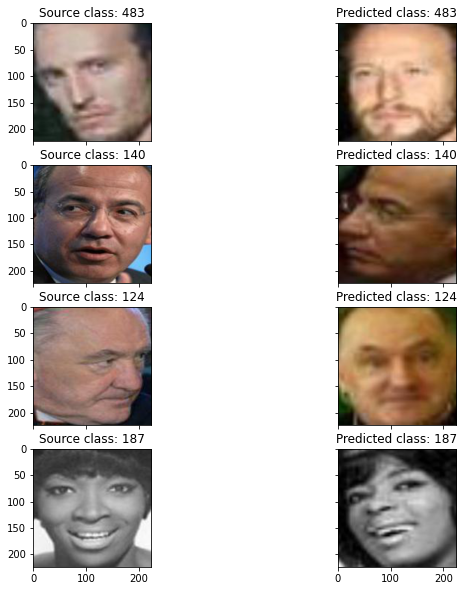

In [16]:
Ni = 4
RESCALE_SIZE = 224

fig, ax = plt.subplots(nrows=Ni, ncols=2,figsize=(10, 10), \
                        sharey=True, sharex=True)

for i in range(Ni):
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0, len(predictions)))
        source, predicted, source_class, predicted_class = face_images_class_dataset[random_characters]
        
        ax[i ,0].imshow(source)
        ax[i ,0].set_title('Source class: ' + str(source_class))
        ax[i ,1].imshow(predicted)
        ax[i ,1].set_title('Predicted class: ' + str(predicted_class))

In [18]:
# This one for submission
class FaceClassDataset(Dataset):
    """
    Class Dataset only for accuracy score 
    """
    def __init__(self, predictions, names):
        super().__init__()

        self.predictions = predictions
        self.names = names

    
    def __len__(self):
         return len(predictions)
  
    def __getitem__(self, index):
        
        source_num = predictions[index][0].split('/')[-1].split('.')[-2]
        predicted_num = predictions[index][1].split('/')[-1].split('.')[-2]
        predicted_class = names[names['image'] == str(predicted_num)]['class'].iloc[0]
        return str(source_num)+'.jpg', predicted_class

In [21]:
face_class_dataset = FaceClassDataset(predictions, names)

In [23]:
final_preds = []
for i, face_pair in tqdm(
    enumerate(face_class_dataset), 
    total = len(face_class_dataset)
):
    final_preds.append(face_pair)

100%|██████████| 169396/169396 [01:17<00:00, 2188.23it/s]


In [24]:
# 0.71478 score
pd.DataFrame(final_preds).to_csv('facenet_preds_1201_1.csv', header=['Id', 'random'], index=None)